In [45]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [46]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [15]:
#!mkdir ../yaml/august-5-2022
#!mkdir ../output/august-5-2022

In [76]:
# simulation parameters
time_limit = 500
time_step = 5
transcript_lens = [300, 300]
cellular_transcript_copy_number = 50
transgene_transcript_copy_numbers = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 300, 500]
ribosome_copy_number = 100
total_trna = 100
ribosome_binding_rates = [[1000.0, 1000.0], [10000.0, 10000.0], [100000.0, 100000.0]]
trna_charging_rate = 100.0
transcript_names = ["cellularProtein", "GFP"]
trna_props = (0.5, 0.5)
codon_comps_1 = (0.5, 0.5)
codon_comps_2 = (0.5, 0.5)

date = "august-5-2022"

In [6]:
serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                               codon_comps=[codon_comps_1, codon_comps_2],
                                               trna_proportion=trna_props,
                                               transcript_names=transcript_names,
                                               time_limit=time_limit,
                                               time_step=time_step)
serializer.serialize(f"../yaml/{date}")
conf = serializer.filename()

In [77]:
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for transgene_copy in transgene_transcript_copy_numbers:
        for binding_rate in ribosome_binding_rates:
            for seed in range(1, 4):
                cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{conf} {seed} {cellular_transcript_copy_number} {transgene_copy} " + \
                  f"{ribosome_copy_number} {total_trna} {binding_rate[0]} {binding_rate[1]} {trna_charging_rate} {trna_charging_rate} ../output/{date}"
                stream.write(cmd)
                stream.write("\n")

In [81]:
ribosome_binding_rates = [[1000000.0, 1000000.0], [10000000.0, 10000000.0]]

In [82]:
with open(f"../scripts/cmd_files/{date}-2.txt", "w") as stream:
    for transgene_copy in transgene_transcript_copy_numbers:
        for binding_rate in ribosome_binding_rates:
            for seed in range(1, 4):
                cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{conf} {seed} {cellular_transcript_copy_number} {transgene_copy} " + \
                  f"{ribosome_copy_number} {total_trna} {binding_rate[0]} {binding_rate[1]} {trna_charging_rate} {trna_charging_rate} ../output/{date}"
                stream.write(cmd)
                stream.write("\n")

In [84]:
ribosome_binding_rates = [[1000.0, 1000.0], [10000.0, 10000.0], [100000.0, 100000.0], [1000000.0, 1000000.0], [10000000.0, 10000000.0]]

In [50]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = pd.read_csv(f"{path}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    if tmp.empty:
        times = df_master["time"].to_list()
        dedup_times = []
        [dedup_times.append(x) for x in times if x not in dedup_times]
        next_best_time = take_closest(dedup_times, time)
        tmp = df_master.loc[df_master['time'] == next_best_time].groupby(["species"])["protein"].mean().reset_index()
    #tmp["codon_comp"] = perc_good
    return tmp

In [85]:
df_master = None

for binding_rate in ribosome_binding_rates:
    df_tmp = None
    for transgene_copy in transgene_transcript_copy_numbers:
        path = f"../output/{date}/two_codon_multi_transcript_0.5_0.5_0.5_0.5_0.5_0.5" + \
               f"_{cellular_transcript_copy_number}_{transgene_copy}_{ribosome_copy_number}_{total_trna}" + \
               f"_{binding_rate[0]}_{binding_rate[1]}_{trna_charging_rate}_{trna_charging_rate}"
        tmp = get_average_protein(path, 0.5, 500, 3)
        tmp["transgene_copy"] = transgene_copy
        tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
        if df_tmp is not None:
            df_tmp = df_tmp.append(tmp, ignore_index=True)
        else:
            df_tmp = tmp
    df_tmp["binding_rate"] = binding_rate[0]
    if df_master is not None:
        df_master = df_master.append(df_tmp, ignore_index=True)
    else:
        df_master = df_tmp

df_master

,species,protein,transgene_copy,binding_rate
0,ATA_charged,49.000000,0,1000.0
1,ATA_uncharged,1.000000,0,1000.0
2,TTT_charged,50.000000,0,1000.0
3,TTT_uncharged,0.000000,0,1000.0
4,__cellularProtein_rbs,50.000000,0,1000.0
...,...,...,...,...
660,TTT_uncharged,14.000000,500,10000000.0
661,__GFP_rbs,498.333333,500,10000000.0
662,__cellularProtein_rbs,50.000000,500,10000000.0
663,free ribosome,0.000000,500,10000000.0


In [86]:
pivot = df_master.pivot(index = ["binding_rate", "transgene_copy"], columns = "species", values = "protein").reset_index()
pivot["GFP"] = pivot["GFP"].fillna(0)
#pivot["cellularProtein_transformed"] = pivot["cellularProtein"] / pivot["cellularProtein"].max()
pivot["cellularProtein_transformed"] = pivot["cellularProtein"].groupby(pivot.binding_rate).transform(lambda x: x/x.max())
pivot["GFP_transformed"] = pivot["GFP"] / (pivot["GFP"] + pivot["cellularProtein"])
pivot

species,binding_rate,transgene_copy,ATA_charged,ATA_uncharged,GFP,TTT_charged,TTT_uncharged,__GFP_rbs,__cellularProtein_rbs,cellularProtein,free ribosome,cellularProtein_transformed,GFP_transformed
0,1000.0,0,49.000000,1.000000,0.000000,50.000000,0.000000,NaN,50.000000,279.000000,96.000000,1.000000,0.000000
1,1000.0,10,47.000000,3.000000,12.000000,49.000000,1.000000,10.000000,50.000000,255.000000,92.000000,0.913978,0.044944
2,1000.0,20,50.000000,0.000000,43.000000,48.000000,2.000000,20.000000,50.000000,236.000000,96.000000,0.845878,0.154122
3,1000.0,30,50.000000,0.000000,84.000000,48.000000,2.000000,30.000000,50.000000,275.000000,96.000000,0.985663,0.233983
4,1000.0,40,48.666667,1.333333,147.000000,49.000000,1.000000,40.000000,50.000000,239.333333,94.666667,0.857826,0.380500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,10000000.0,100,34.000000,16.000000,4352.333333,32.333333,17.666667,98.666667,50.000000,1123.666667,0.333333,0.206026,0.794802
71,10000000.0,150,30.666667,19.333333,4956.000000,32.666667,17.333333,148.666667,49.666667,530.666667,0.000000,0.097299,0.903281
72,10000000.0,200,30.333333,19.666667,5161.000000,28.666667,21.333333,199.000000,50.000000,325.666667,0.000000,0.059712,0.940644
73,10000000.0,300,33.666667,16.333333,5335.000000,33.333333,16.666667,298.333333,49.666667,156.333333,0.000000,0.028664,0.971531


Text(0, 0.5, 'Cellular protein')

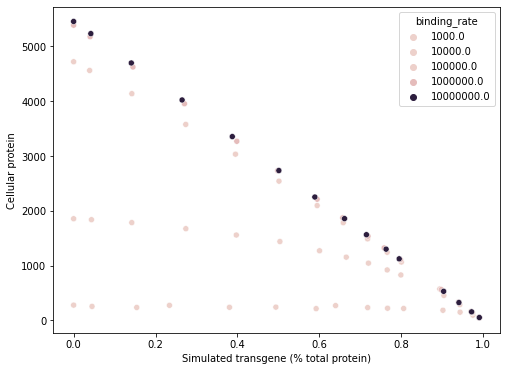

In [92]:
sns.scatterplot(data = pivot, x = "GFP_transformed", y = "cellularProtein", hue = "binding_rate")
rcParams['figure.figsize'] = [8, 6]
plt.xlabel("Simulated transgene (% total protein)")
plt.ylabel("Cellular protein")

Text(0, 0.5, 'Simulated protein')

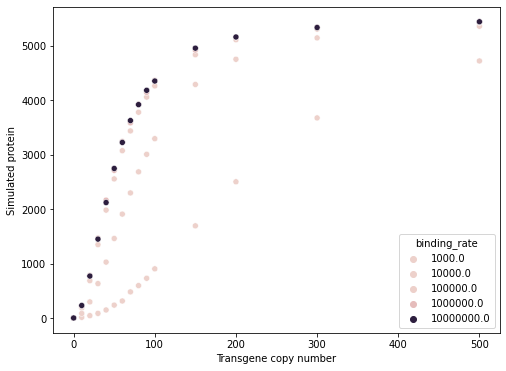

In [90]:
sns.scatterplot(data = pivot, x = "transgene_copy", y = "GFP", hue = "binding_rate")
plt.xlabel("Transgene copy number")
plt.ylabel("Simulated protein")